<a href="https://colab.research.google.com/github/hexlth/forage-jpmc-swe-task-1/blob/main/Deep_Learning_with_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install timm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=9537dc8edbc1e3e68b69fbfc0a15b0480dc8d80df0cf34801e8157183894282b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=fc5dca4530f9e489613a1ed38ab0a970e33a5d96c21981e3a74e6f5ecf475e0f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [4]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 19.68 MiB/s, done.
Updating files: 100% (12939/12939), done.


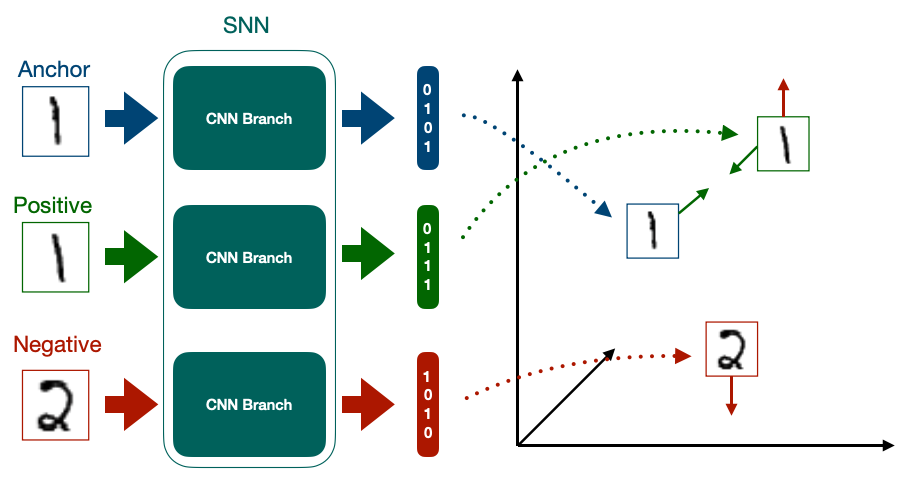

# Imports

In [5]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configs


In [7]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[14]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

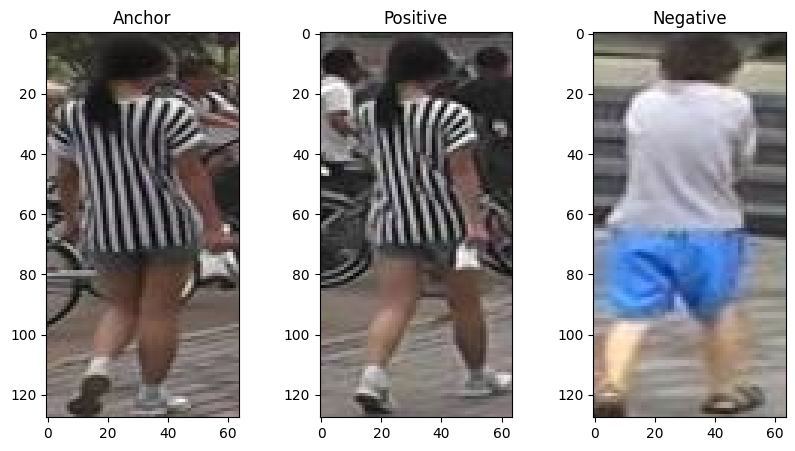

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

        return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


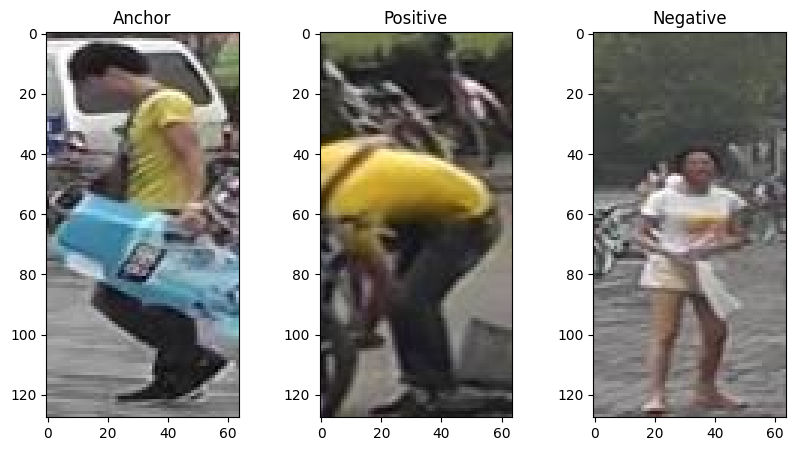

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [18]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [19]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() #ON dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [21]:
def eval_fn(model, dataloader, criterion):

  model.eval() #OFF dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Saved_Weight_Success")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Saved_Weight_Success
EPOCHS : 1 train_loss : 0.5642878031730652 valid_loss : 0.566103772521019


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Saved_Weight_Success
EPOCHS : 2 train_loss : 0.28346855372190477 valid_loss : 0.3143005549907684


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Saved_Weight_Success
EPOCHS : 3 train_loss : 0.18297582596540451 valid_loss : 0.2861991775035858


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Saved_Weight_Success
EPOCHS : 4 train_loss : 0.10751232795417309 valid_loss : 0.1551080673933029


100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


EPOCHS : 5 train_loss : 0.052791796252131463 valid_loss : 0.17407681465148925


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


EPOCHS : 6 train_loss : 0.05048769354820251 valid_loss : 0.18901966214179994


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


EPOCHS : 7 train_loss : 0.03805114798247814 valid_loss : 0.19478160083293916


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


EPOCHS : 8 train_loss : 0.04416465491056442 valid_loss : 0.16863487601280214


100%|██████████| 25/25 [00:03<00:00,  7.91it/s]


EPOCHS : 9 train_loss : 0.038121170550584796 valid_loss : 0.22052083522081375


100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


EPOCHS : 10 train_loss : 0.04066142275929451 valid_loss : 0.22271726220846177


100%|██████████| 25/25 [00:03<00:00,  7.83it/s]


EPOCHS : 11 train_loss : 0.06361437641084194 valid_loss : 0.21561253309249878


100%|██████████| 25/25 [00:03<00:00,  8.01it/s]


EPOCHS : 12 train_loss : 0.04480703622102737 valid_loss : 0.1821376657485962


100%|██████████| 25/25 [00:03<00:00,  7.89it/s]


Saved_Weight_Success
EPOCHS : 13 train_loss : 0.026574159562587737 valid_loss : 0.12457748353481293


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


EPOCHS : 14 train_loss : 0.048812825381755826 valid_loss : 0.19081698834896088


100%|██████████| 25/25 [00:03<00:00,  7.76it/s]

EPOCHS : 15 train_loss : 0.04014191173017025 valid_loss : 0.1311676913499832


# Get Anchor Embeddings

In [24]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c, h, w)-(l, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc


In [25]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-25-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:45<00:00, 

In [26]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.607071,-0.834872,-0.877420,-0.818185,0.585401,-0.412194,-1.234509,-0.250153,-1.343800,...,-0.087326,1.125976,0.627404,-0.554314,-0.217266,-0.031039,0.060135,-0.541790,1.289338,0.264661
1,1420_c3s3_061978_03.jpg,0.335851,-0.730664,-0.718793,-0.403181,-0.015724,0.061105,-1.000079,-0.192691,-0.889083,...,-0.062992,0.965324,0.667366,0.113673,-0.121290,-0.002554,0.010316,-0.402601,0.785444,0.173318
2,1420_c5s3_062565_05.jpg,0.374446,-0.586302,-0.614776,-0.487441,0.723978,-0.438225,-1.270568,-0.124229,-1.218092,...,-0.198947,1.164704,0.465561,-0.629321,-0.039006,-0.105461,0.149604,-0.216887,1.055556,0.424412
3,1420_c6s3_085592_04.jpg,0.033659,-0.906970,-0.791526,-0.559613,-0.308690,0.219877,-0.672314,-0.051561,-0.417846,...,-0.075757,0.502536,0.464327,0.315174,-0.097409,0.152700,-0.263365,-0.701305,0.686601,-0.002170
4,0663_c5s3_085987_03.jpg,0.003239,-0.085048,-0.990253,-0.538213,0.092248,-0.194566,-0.127720,0.656421,-0.990300,...,0.471720,-0.276910,-0.633857,-0.375826,-0.241839,0.444435,-0.314400,-0.562885,0.367744,0.192985


# Inference

In [27]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [28]:
idx = 0
img_name = df['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [29]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [30]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
    distance = np.append(distance,dist)

In [31]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


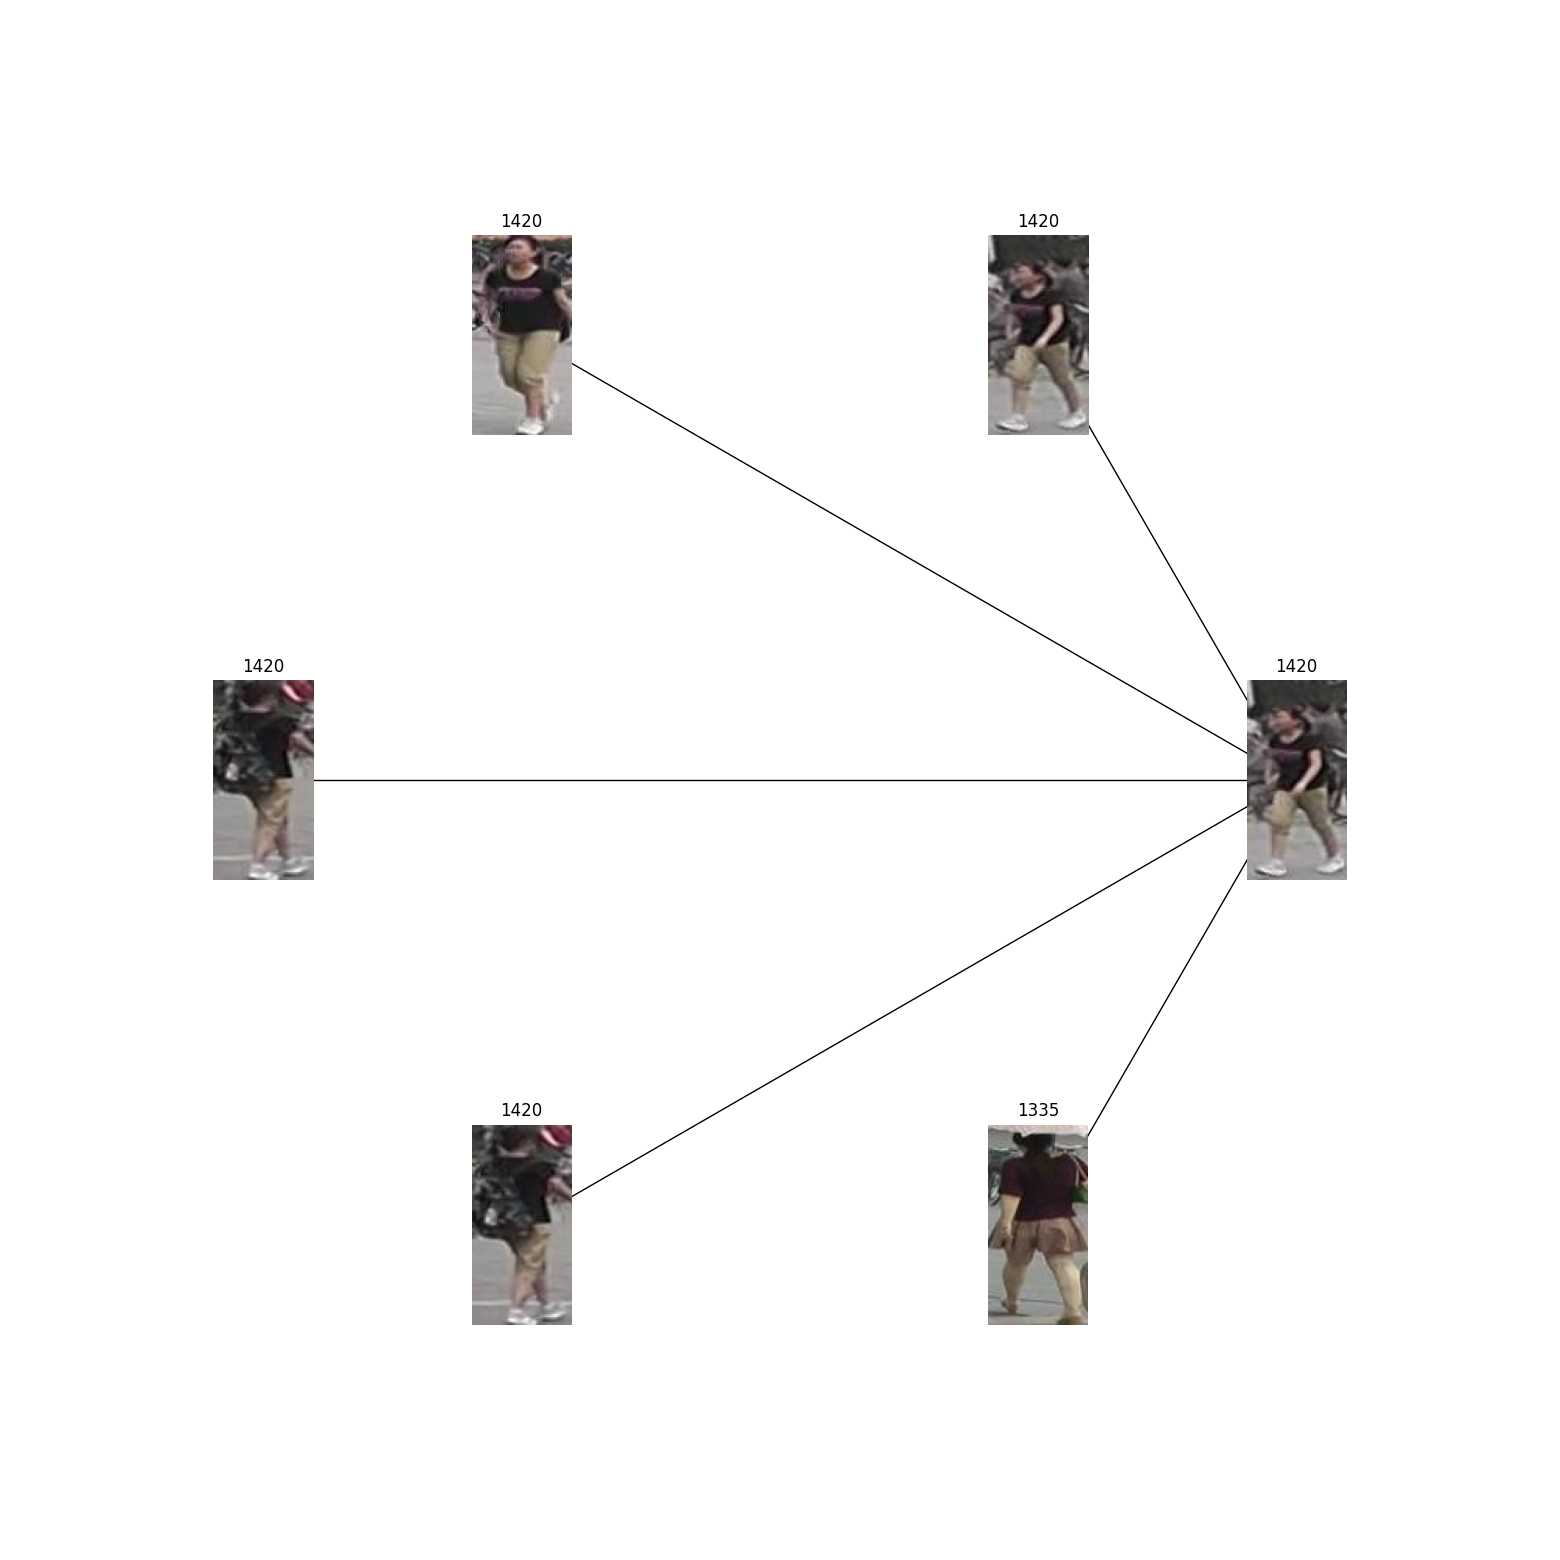

In [32]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);